<a href="https://colab.research.google.com/github/maralhi/Sensors_models/blob/main/02_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Projects_ML/Project_Sensors/df_cl.csv'

df = pd.read_csv(file_path)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail,is_outlier_footfall,is_outlier_CS,is_outlier_Temperature,footfall_tempMode_interaction
0,0,7,7,1,6,6,36,3,1,1,False,False,True,0
1,190,1,3,3,5,1,20,4,1,0,False,False,True,190
2,31,7,2,2,6,1,24,6,1,0,False,False,True,217
3,83,4,3,4,5,1,28,6,1,0,False,False,True,332
4,640,7,5,6,4,0,68,6,1,0,True,False,True,4480


In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols].describe().round(2)


,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail,footfall_tempMode_interaction
count,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00,944.00
mean,306.38,3.73,4.33,2.94,5.39,2.84,47.04,4.57,16.33,0.42,1201.34
std,1082.61,2.68,1.44,1.38,1.27,2.27,16.42,1.60,5.97,0.49,5278.19
min,0.00,0.00,1.00,1.00,1.00,0.00,19.00,1.00,1.00,0.00,0.00
25%,1.00,1.00,3.00,2.00,5.00,1.00,34.00,3.00,14.00,0.00,0.00
50%,22.00,3.00,4.00,3.00,6.00,2.00,44.00,4.00,17.00,0.00,40.00
75%,110.00,7.00,6.00,4.00,6.00,5.00,58.00,6.00,21.00,1.00,280.00
max,7300.00,7.00,7.00,7.00,7.00,6.00,91.00,7.00,24.00,1.00,51100.00


In [ ]:
def detect_anomalies_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

for col in numeric_cols:
    anomalies = detect_anomalies_iqr(df, col)
    print(f"{col} - {len(anomalies)} detected anomalies")


footfall - 154 detected anomalies
tempMode - 0 detected anomalies
AQ - 0 detected anomalies
USS - 0 detected anomalies
CS - 87 detected anomalies
VOC - 0 detected anomalies
RP - 0 detected anomalies
IP - 0 detected anomalies
Temperature - 48 detected anomalies
fail - 0 detected anomalies
footfall_tempMode_interaction - 148 detected anomalies


In [ ]:
from scipy.stats import zscore

z_scores = df[numeric_cols].apply(zscore)
threshold = 3
anomalies_z = (abs(z_scores) > threshold)
print(anomalies_z.sum())


footfall                         18
tempMode                          0
AQ                                0
USS                               0
CS                               13
VOC                               0
RP                                0
IP                                0
Temperature                       0
fail                              0
footfall_tempMode_interaction    19
dtype: int64


In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(df[numeric_cols])
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})
print(df['anomaly'].value_counts())


anomaly
0    896
1     48
Name: count, dtype: int64


In [ ]:

df_anomalies = df[df['anomaly'] == 1]
df_normal = df[df['anomaly'] == 0]

print(df_anomalies)
print(df_normal)


     footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail  \
4         640         7   5    6   4    0  68   6            1     0   
10       1600         0   3    2   4    4  26   2            1     0   
14       1000         7   5    7   4    0  74   1            1     0   
29        450         3   4    7   1    0  34   3            2     0   
34        640         7   7    5   7    4  33   3            3     1   
37         62         6   7    2   7    5  75   3            3     1   
43        100         1   7    7   5    6  35   2            3     0   
46          0         7   4    3   1    6  45   3            3     1   
61       3500         7   2    2   6    0  34   4            4     0   
77         32         5   3    7   4    1  65   1            5     0   
78        390         7   3    6   2    2  24   3            5     0   
105      3500         0   4    3   7    0  91   1            7     0   
115      7300         5   7    7   6    3  21   2            8  

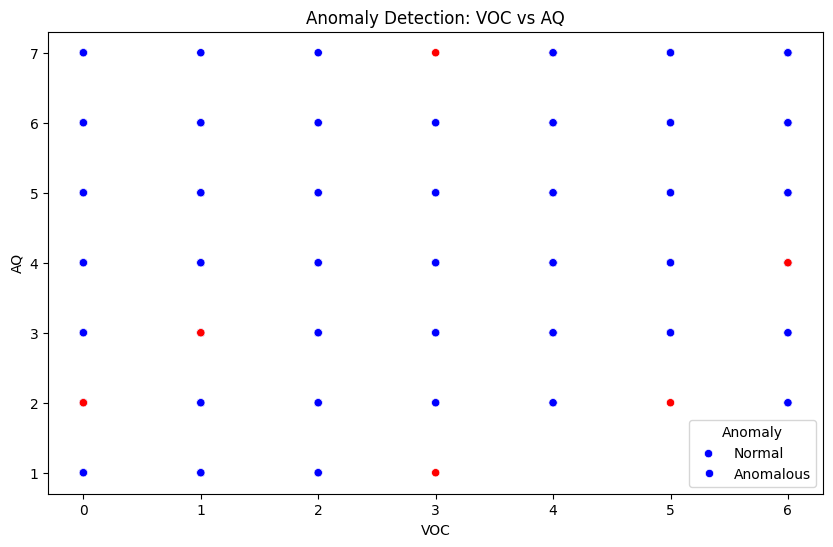

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

x_var = 'VOC'
y_var = 'AQ'

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=x_var, y=y_var, hue='anomaly', palette={0: 'blue', 1: 'red'})
plt.title(f'Anomaly Detection: {x_var} vs {y_var}')
plt.legend(title='Anomaly', labels=['Normal', 'Anomalous'])
plt.show()
